In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic as geopy_geodesic

In [2]:
def mean_geodetic_distance(y_true_lat, y_true_long, y_pred_lat, y_pred_long):
    distances = [
        geopy_geodesic((true_lat, true_long), (pred_lat, pred_long)).km
        for true_lat, true_long, pred_lat, pred_long in zip(
            y_true_lat, y_true_long, y_pred_lat, y_pred_long
        )
    ]
    return np.mean(distances)

## Load data

In [3]:
train_df = pd.read_csv("../data/ais_train.csv", sep="|")
train_df["time"] = pd.to_datetime(train_df["time"])
test_df = pd.read_csv("../data/ais_test.csv")
test_df["time"] = pd.to_datetime(test_df["time"])

ports_df = pd.read_csv("../data/ports.csv", sep="|")
schedules_df = pd.read_csv("../data/schedules_to_may_2024.csv", sep="|")
vessels_df = pd.read_csv("../data/vessels.csv", sep="|")
# train_df["etaRaw"] = pd.to_datetime(train_df["etaRaw"], format="%Y/%m/%d %H:%M")
train_df.tail()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b
1522064,2024-05-07 23:59:08,336.0,14.3,5,337,0,05-07 23:00,38.98635,-75.13275,62080cff66fc0a8e43c6123a,61d38528b7b7526e1adf3e6f


In [4]:
test_start = "2024-05-08 00:00:00"

## Preprocessing and feature engineering

#### Drop vessels with very few rows

In [5]:
train_df = train_df[
    ~train_df["vesselId"].isin(["61e9f3adb937134a3c4bfe37", "61e9f3cbb937134a3c4bff09"])
]

#### Remove duplicated vessel

In [6]:
duplicated_vessel = "clh6aqawa0001gh0zmijpuho1"
duplicated_from = "63d27587e3fba838ce820405"
train_df = train_df[train_df["vesselId"] != duplicated_vessel]
# test_df.loc[test_df["vesselId"] == duplicated_vessel, "vesselId"] = duplicated_from

#### Stack train and test

In [7]:
train_df["scaling_factor"] = np.nan
train_df["ID"] = -1
full_df = pd.concat([train_df, test_df]).sort_values(["vesselId", "time"]).reset_index()

#### Util

In [8]:
def df_to_gdf(
    df: pd.DataFrame, longitude_col="longitude", latitude_col="latitude"
) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[longitude_col], df[latitude_col]),
        crs="EPSG:4326",
    )

In [9]:
full_df["time_diff"] = full_df.groupby("vesselId")["time"].diff().astype(int) // 10**9

# Assume time diff before first msg was 20 min
full_df.loc[full_df["time_diff"] < 0, "time_diff"] = 60 * 20

In [10]:
train_mask = full_df["ID"] == -1
full_df.loc[train_mask, "etaRaw"] = pd.to_datetime(
    "2024-" + full_df.loc[train_mask, "etaRaw"], errors="coerce"
)

#### Add prev positions, distance, fwd_azimuth, computed sog

In [11]:
from pyproj import Geod

In [12]:
full_df[["prev_lat", "prev_lng"]] = full_df.groupby("vesselId")[
    ["latitude", "longitude"]
].shift()

In [13]:
geodesic = Geod(ellps="WGS84")
fwd_azimuth, back_azimuth, distance = geodesic.inv(
    full_df["prev_lng"],
    full_df["prev_lat"],
    full_df["longitude"],
    full_df["latitude"],
)

full_df["distance"] = distance / (1000 * 1.852)
full_df["fwd_azimuth"] = fwd_azimuth
full_df["prev_distance"] = full_df["distance"].shift()
full_df["prev_fwd_azimuth"] = full_df["fwd_azimuth"].shift()

# lng, lat, back_azimuth = geodesic.fwd(
#     train_df["prev_lng"], train_df["prev_lat"], fwd_azimuth, distance
# )
# train_df["lng_test"] = lng
# train_df["lat_test"] = lat

In [14]:
full_df["computed_sog"] = full_df["distance"] / (full_df["time_diff"] / 3600)
full_df["prev_sog"] = full_df["computed_sog"].shift()

In [15]:
speed_limit = 50

full_df = full_df[(full_df["computed_sog"] < speed_limit) | (full_df["ID"] != -1)]

#### Replace missing/default values with NaN

In [16]:
full_df.loc[full_df["cog"] >= 360, "cog"] = np.nan
full_df.loc[full_df["sog"] >= 102.3, "sog"] = np.nan
full_df.loc[abs(full_df["rot"]) >= 128, "rot"] = np.nan
full_df.loc[full_df["heading"] > 360, "heading"] = np.nan
full_df.loc[full_df["navstat"] >= 9, "navstat"] = np.nan

#### Merge vessels df

In [17]:
full_df = full_df.merge(
    vessels_df[
        [
            "shippingLineId",
            "vesselId",
            "CEU",
            "DWT",
            "GT",
            "vesselType",
            "breadth",
            "length",
            "yearBuilt",
        ]
    ],
    on="vesselId",
    how="left",
)

#### Merge ports df (calculate distance to closest port)

In [18]:
closest_ports = pd.read_csv("../data/ports.csv", sep="|").rename(
    {
        "portId": "closest_port",
        "latitude": "latitude_port",
        "longitude": "longitude_port",
    },
    axis=1,
)

In [19]:
orig_cols = full_df.columns.to_list()
distance_col = "dist_to_port"

ports_gdf = df_to_gdf(
    closest_ports, longitude_col="longitude_port", latitude_col="latitude_port"
).to_crs(epsg="3857")

full_gdf = df_to_gdf(full_df, longitude_col="prev_lng", latitude_col="prev_lat").to_crs(
    epsg="3857"
)
full_gdf = full_gdf.sjoin_nearest(ports_gdf, how="left", distance_col=distance_col)
full_df[[distance_col, "prev_closest_port", "latitude_port", "longitude_port"]] = (
    full_gdf[[distance_col, "closest_port", "latitude_port", "longitude_port"]]
)

In [20]:
def find_closest_port_for_row(row, longitude_col, latitude_col):
    row_gdf = df_to_gdf(
        row, longitude_col=longitude_col, latitude_col=latitude_col
    ).to_crs(epsg="3857")

    row_with_nearest_port = row_gdf.sjoin_nearest(
        ports_gdf, how="left", distance_col="dist_to_port"
    )

    # Extract the closest port info
    closest_port = row_with_nearest_port["closest_port"].values
    dist_to_port = row_with_nearest_port["dist_to_port"].values
    latitude_port = row_with_nearest_port["latitude_port"].values
    longitude_port = row_with_nearest_port["longitude_port"].values

    return closest_port, dist_to_port, latitude_port, longitude_port

#### Add temporal features

In [21]:
def add_temporal_cols(df: pd.DataFrame, time_col="time") -> pd.DataFrame:
    day_s = 24 * 60 * 60
    year_s = (366) * day_s
    month_s = year_s // 12
    timestamp_s = (df[time_col] - pd.Timestamp("2024-01-01")) // pd.Timedelta("1s")

    df[f"{time_col}_day_sin"] = np.sin(timestamp_s * (2 * np.pi / day_s))
    df[f"{time_col}_day_cos"] = np.cos(timestamp_s * (2 * np.pi / day_s))
    df[f"{time_col}_year_sin"] = np.sin(timestamp_s * (2 * np.pi / year_s))
    df[f"{time_col}_year_cos"] = np.cos(timestamp_s * (2 * np.pi / year_s))
    df[f"{time_col}_month_sin"] = np.sin(timestamp_s * (2 * np.pi / month_s))
    df[f"{time_col}_month_cos"] = np.cos(timestamp_s * (2 * np.pi / month_s))
    cols = [
        f"{time_col}_day_sin",
        f"{time_col}_day_cos",
        f"{time_col}_year_sin",
        f"{time_col}_year_cos",
        f"{time_col}_month_sin",
        f"{time_col}_month_cos",
    ]
    return df, cols


full_df, time_cols = add_temporal_cols(full_df, "time")

#### Categorical encoding

In [22]:
from category_encoders.count import CountEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

In [23]:
# Counts of ports might be useful for estimating the size / popularity of the port
count_ports_encoder = CountEncoder(handle_missing="value", handle_unknown=-1)

full_df.loc[~full_df["prev_closest_port"].isna(), "closest_port_count"] = (
    count_ports_encoder.fit_transform(
        full_df.loc[~full_df["prev_closest_port"].isna(), "prev_closest_port"].values
    ).values
)

In [24]:
shipping_line_encoder = CountEncoder()
full_df["shipping_line_count"] = shipping_line_encoder.fit_transform(
    full_df["shippingLineId"].values
)

In [25]:
encoded_cols = [
    "vesselType_83.0",
    "vesselType_21.0",
    "vesselType_14.0",
]

one_hot = OneHotEncoder(cols=["vesselType"], handle_missing="value", use_cat_names=True)
encoded = one_hot.fit_transform(full_df["vesselType"])

full_df[encoded_cols] = encoded[encoded_cols]

In [26]:
# Encode vesselId by target encoding for lat, lng (i.e. mix of group mean vs. global mean)
train_mask = full_df["ID"] == -1
vessel_lat_encoder = TargetEncoder(cols=["vesselId"], min_samples_leaf=20, smoothing=10)
vessel_lng_encoder = TargetEncoder(cols=["vesselId"], min_samples_leaf=20, smoothing=10)
vessel_lat_encoder.fit(
    full_df.loc[train_mask, "vesselId"], full_df.loc[train_mask, "latitude"]
)
vessel_lng_encoder.fit(
    full_df.loc[train_mask, "vesselId"], full_df.loc[train_mask, "longitude"]
)

full_df["vessel_lat"] = vessel_lat_encoder.transform(full_df["vesselId"])
full_df["vessel_lng"] = vessel_lng_encoder.transform(full_df["vesselId"])

#### Finalize dataset

In [27]:
features = (
    [
        "time_diff",
        "prev_lat",
        "prev_lng",
        "prev_sog",
        "prev_distance",
        "prev_fwd_azimuth",
        "CEU",
        "DWT",
        "GT",
        "breadth",
        "length",
        "yearBuilt",
        "dist_to_port",
        "latitude_port",
        "longitude_port",
    ]
    + time_cols
    + encoded_cols
    + [
        "closest_port_count",
        "shipping_line_count",
        "vessel_lat",
        "vessel_lng",
    ]
)

targets = ["longitude", "latitude", "distance", "fwd_azimuth"]

In [28]:
train_mask = full_df["ID"] == -1
val_cutoff = pd.Timestamp(full_df.loc[train_mask, "time"].max()) - pd.Timedelta("5d")
val_df = full_df[(full_df["time"] > val_cutoff) & (full_df["time"] < test_start)]
train_df = full_df[full_df["time"] < val_cutoff]

## Training

In [29]:
import xgboost as xgb

#### Models

In [30]:
model_lng = xgb.XGBRegressor(
    **{"alpha": 0.05, "max_depth": 12, "n_estimators": 100, "random_state": 123}
)
model_lat = xgb.XGBRegressor(
    **{"alpha": 0.05, "max_depth": 12, "n_estimators": 100, "random_state": 123}
)

#### Training

In [31]:
model_lng.fit(
    train_df[features],
    train_df[targets]["longitude"],
    # sample_weight=train_df["time_diff"],
    verbose=True,
)

XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [32]:
model_lat.fit(
    train_df[features],
    train_df[targets]["latitude"],
    # sample_weight=train_df["time_diff"],
    verbose=True,
)

XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [33]:
val_lng = model_lng.predict(val_df[features])
val_lat = model_lat.predict(val_df[features])

In [34]:
mean_geodetic_distance(
    y_true_lat=val_df["latitude"],
    y_true_long=val_df["longitude"],
    y_pred_lat=val_lat,
    y_pred_long=val_lng,
)

23.46511057603201

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

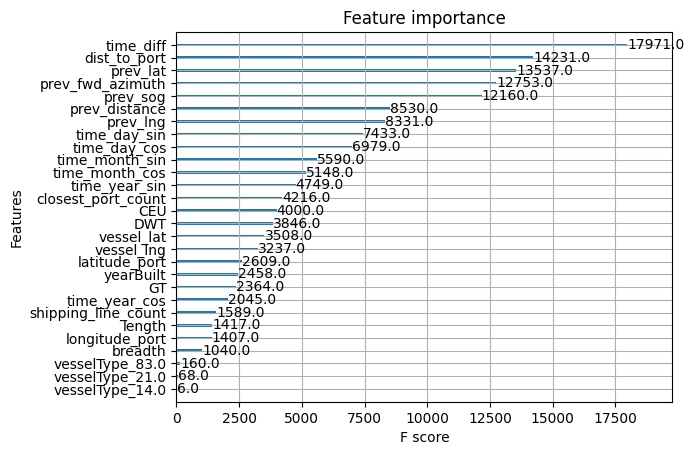

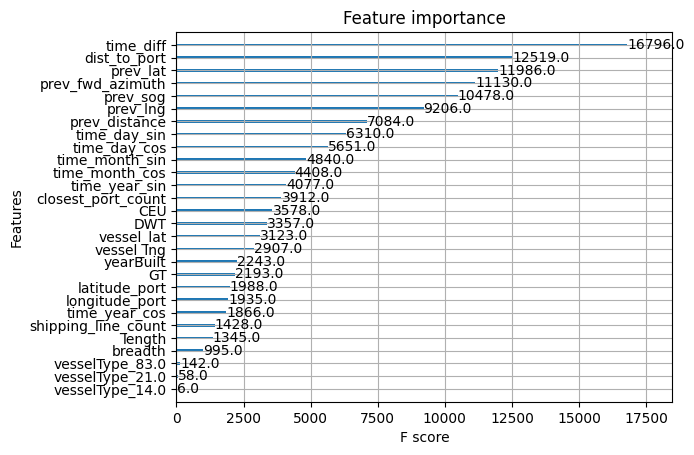

In [35]:
from xgboost import plot_importance

plot_importance(model_lat)
plot_importance(model_lng)

#### Evaluate on last 5 days of train set autoregressively

In [36]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [38]:
lng_pred = []
lat_pred = []
total_steps = val_df.shape[0]

with tqdm(total=total_steps) as progress_bar:
    for vesselId in val_df["vesselId"].unique():
        vessel_rows = val_df[val_df["vesselId"] == vesselId].copy()

        steps = vessel_rows.shape[0]
        vessel_rows["step"] = np.arange(steps)

        for i in range(steps):
            row = vessel_rows.loc[vessel_rows["step"] == i]
            longitude = model_lng.predict(row[features]).item()
            latitude = model_lat.predict(row[features]).item()
            lng_pred.append(longitude)
            lat_pred.append(latitude)

            fwd_azimuth, back_azimuth, distance = geodesic.inv(
                row["prev_lng"].item(),
                row["prev_lat"].item(),
                longitude,
                latitude,
            )
            distance = distance / (1.852 * 1000)
            sog = distance / (row["time_diff"].item() / 3600)
            closest_port, dist_to_port, latitude_port, longitude_port = (
                find_closest_port_for_row(
                    row[["prev_lat", "prev_lng"]],
                    latitude_col="prev_lat",
                    longitude_col="prev_lng",
                )
            )
            closest_port_count = count_ports_encoder.transform(
                closest_port
            ).values.item()

            if i < steps - 1:
                vessel_rows.loc[
                    vessel_rows["step"] == i + 1,
                    [
                        "prev_distance",
                        "prev_fwd_azimuth",
                        "prev_lat",
                        "prev_lng",
                        "prev_sog",
                        "closest_port_count",
                        "dist_to_port",
                        "latitude_port",
                        "longitude_port",
                    ],
                ] = [
                    distance,
                    fwd_azimuth,
                    latitude,
                    longitude,
                    sog,
                    closest_port_count,
                    dist_to_port.item(),
                    latitude_port.item(),
                    longitude_port.item(),
                ]

            progress_bar.update()

100%|██████████| 60242/60242 [12:56<00:00, 77.61it/s]


In [39]:
val_df["lat_pred"] = lat_pred
val_df["lng_pred"] = lng_pred

first_day = val_df[val_df["time"] < "2024-05-04"]
mean_geodetic_distance(
    y_true_lat=first_day["latitude"],
    y_true_long=first_day["longitude"],
    y_pred_lat=first_day["lat_pred"],
    y_pred_long=first_day["lng_pred"],
)

363.6210978888487

In [40]:
mean_geodetic_distance(
    y_true_lat=val_df["latitude"],
    y_true_long=val_df["longitude"],
    y_pred_lat=val_df["lat_pred"],
    y_pred_long=val_df["lng_pred"],
)

1075.5904200253888